# IDR to CNY, CAD, and MYR currency model

In [1]:
%run helper_functions_and_libraries.py
logging.set_verbosity(logging.ERROR)

In [2]:
df = pd.read_csv('currency_data_10_years.csv', parse_dates=['date'])

In [3]:
display(df.head())

,date,EUR,USD,JPY,GBP,SGD,AUD,CNY,CAD,MYR,RUB
0,2013-05-01,12816.661099,9721.95011,99.794970,15125.789759,7884.025975,9991.932116,1573.729510,9637.238781,3196.705985,311.579294
1,2013-05-02,12696.355896,9727.31307,99.371194,15096.787469,7878.089194,9976.629029,1576.636811,9620.049518,3193.114711,311.787545
2,2013-05-03,12735.428571,9726.93828,98.682506,15125.784565,7879.444847,10024.671009,1576.977359,9628.439345,3201.788787,312.272389
3,2013-05-04,12758.622548,9729.21521,98.372041,15148.170100,7886.016560,10037.051582,1577.842772,9643.293465,3204.827462,313.177271
4,2013-05-05,12719.240307,9697.65758,97.852512,15097.625177,7859.545641,9999.337595,1572.747845,9623.460698,3195.832412,312.291932


In [4]:
df.isnull().sum()

date    0
EUR     0
USD     0
JPY     0
GBP     0
SGD     0
AUD     0
CNY     0
CAD     0
MYR     0
RUB     0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.describe()

,EUR,USD,JPY,GBP,SGD,AUD,CNY,CAD,MYR,RUB
count,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000
mean,15734.162882,13626.586201,121.401374,18653.481260,10082.717169,10260.649080,2069.300203,10754.881120,3404.138908,231.530939
std,1028.194122,1215.902129,10.240113,1282.776928,714.681696,449.989173,140.321208,530.164824,173.826533,46.941534
min,12502.789487,9697.657580,94.607603,14719.776369,7717.296664,8937.081757,1572.747845,9357.856739,2975.634017,102.737302
25%,15022.483609,13190.926920,113.522422,17928.531116,9568.972790,9936.471898,1980.528819,10411.948518,3302.096195,201.594311
50%,15801.743633,13912.643820,120.609803,18781.087788,10247.419202,10276.735571,2091.106976,10746.358863,3423.539036,219.833077
75%,16463.962255,14384.106330,129.598188,19469.502233,10588.733799,10609.276367,2177.005363,11165.293022,3529.477813,237.545901
max,18035.467645,16644.718800,153.504275,22488.120204,11718.909446,11396.359940,2346.805612,12314.949757,3819.207831,384.795234


In [7]:
SPLIT_TIME = 2922
WINDOW_SIZE = 15
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000

## CNY

In [8]:
cny_df = df[['date','CNY']]

In [9]:
display(cny_df.head())
display(cny_df.tail())

,date,CNY
0,2013-05-01,1573.729510
1,2013-05-02,1576.636811
2,2013-05-03,1576.977359
3,2013-05-04,1577.842772
4,2013-05-05,1572.747845


,date,CNY
3648,2023-04-27,2122.230600
3649,2023-04-28,2122.847288
3650,2023-04-29,2122.846296
3651,2023-04-30,2122.366433
3652,2023-05-01,2123.377747


In [10]:
times, series = parse_data_from_df(cny_df, 'CNY')

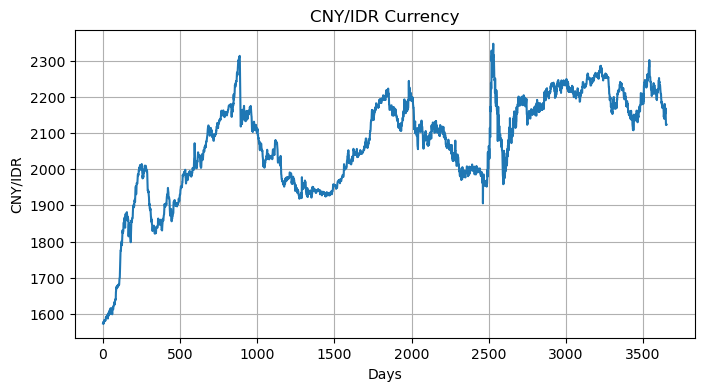

In [11]:
plt.figure(figsize=(8, 4))
plot_series(times, series, title="CNY/IDR Currency", xlabel="Days", ylabel="CNY/IDR")

In [12]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(times, series, SPLIT_TIME, None)

In [13]:
train_set = windowed_dataset(series_train, 
                             window_size=WINDOW_SIZE, 
                             batch_size=BATCH_SIZE, 
                             shuffle_buffer=SHUFFLE_BUFFER_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

In [14]:
val_set = windowed_dataset(series_valid, 
                             window_size=WINDOW_SIZE, 
                             batch_size=BATCH_SIZE, 
                             shuffle_buffer=SHUFFLE_BUFFER_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

In [15]:
def create_model():
    
    # Build the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, input_shape=[WINDOW_SIZE], activation="relu"), 
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1)
    ], name="model_cny")

    return model

In [16]:
# Test your uncompiled model
model = create_model()

# Print the model summary
model.summary()

# Check model compatibility
try:
    model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Model: "model_cny"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2048      
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,209
Trainable params: 6,209
Non-trainable params: 0
_________________________________________________________________
23/23 [==============================] - 2s 69ms/step
Your current architecture is compatible with the windowed dataset! :)


In [17]:
# Get initial weights
init_weights = model.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [18]:
def adjust_learning_rate(dataset, model_to_train):
    
    model = model_to_train
    
    # Set the learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 10**(epoch / 20))
    
    # Select optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
    # optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"])
    
    # Train the model
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [19]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set, model)

Epoch 1/100
23/23 [==============================] - 1s 9ms/step - loss: 347.5375 - mae: 348.0374 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 0s 7ms/step - loss: 58.2374 - mae: 58.7363 - lr: 0.0011
Epoch 3/100
23/23 [==============================] - 0s 7ms/step - loss: 25.7670 - mae: 26.2637 - lr: 0.0013
Epoch 4/100
23/23 [==============================] - 0s 8ms/step - loss: 15.9000 - mae: 16.3921 - lr: 0.0014
Epoch 5/100
23/23 [==============================] - 0s 7ms/step - loss: 16.6048 - mae: 17.0970 - lr: 0.0016
Epoch 6/100
23/23 [==============================] - 0s 7ms/step - loss: 29.7584 - mae: 30.2561 - lr: 0.0018
Epoch 7/100
23/23 [==============================] - 0s 7ms/step - loss: 32.1699 - mae: 32.6679 - lr: 0.0020
Epoch 8/100
23/23 [==============================] - 0s 7ms/step - loss: 31.3203 - mae: 31.8178 - lr: 0.0022
Epoch 9/100
23/23 [==============================] - 0s 7ms/step - loss: 38.8135 - mae: 39.3130 - lr: 0.0025
Epoch 10/100
23/2

23/23 [==============================] - 0s 9ms/step - loss: 96.2104 - mae: 96.7089 - lr: 4.4668
Epoch 75/100
23/23 [==============================] - 0s 10ms/step - loss: 102.6290 - mae: 103.1284 - lr: 5.0119
Epoch 76/100
23/23 [==============================] - 0s 9ms/step - loss: 101.4401 - mae: 101.9395 - lr: 5.6234
Epoch 77/100
23/23 [==============================] - 0s 11ms/step - loss: 104.3322 - mae: 104.8312 - lr: 6.3096
Epoch 78/100
23/23 [==============================] - 0s 12ms/step - loss: 107.3701 - mae: 107.8694 - lr: 7.0795
Epoch 79/100
23/23 [==============================] - 0s 9ms/step - loss: 116.4059 - mae: 116.9045 - lr: 7.9433
Epoch 80/100
23/23 [==============================] - 0s 8ms/step - loss: 104.6533 - mae: 105.1523 - lr: 8.9125
Epoch 81/100
23/23 [==============================] - 0s 9ms/step - loss: 114.1922 - mae: 114.6911 - lr: 10.0000
Epoch 82/100
23/23 [==============================] - 0s 9ms/step - loss: 106.1166 - mae: 106.6154 - lr: 11.2202
Ep

In [20]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [30]:
def compile_model(dataset, model_to_train):
    
    model = model_to_train

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    history = model.fit(dataset,
                        verbose=1,
                        epochs=100,
                        validation_data=val_set,
                        callbacks=[create_model_checkpoint()])   

    return history

In [31]:
history = compile_model(train_set, model)

Epoch 1/100
     20/Unknown - 1s 8ms/step - loss: 386.6677 - mae: 387.1676  INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 2s 59ms/step - loss: 349.3494 - mae: 349.8491 - val_loss: 160.8506 - val_mae: 161.3506
Epoch 2/100
13/23 [===============>..............] - ETA: 0s - loss: 68.9952 - mae: 69.4951 INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 35ms/step - loss: 51.0022 - mae: 51.5009 - val_loss: 16.5984 - val_mae: 17.0927
Epoch 3/100
12/23 [==============>...............] - ETA: 0s - loss: 16.2541 - mae: 16.7483INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 36ms/step - loss: 17.0058 - mae: 17.4985 - val_loss: 13.1715 - val_mae: 13.6603
Epoch 4/100
23/23 [==============================] - 0s 11ms/step - loss: 18.5003 - mae: 18.9950 - val_loss: 13.6286 - val_mae: 14.1181
Epoch 5/100
23/23 [==============================] - 0s 12ms/step - loss: 16.0661 - mae: 16.5584 - val_loss: 13.2885 - val_mae: 13.7784
Epoch 6/100
18/23 [======================>.......] - ETA: 0s - loss: 16.7795 - mae: 17.2725INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 43ms/step - loss: 16.2921 - mae: 16.7846 - val_loss: 12.8739 - val_mae: 13.3662
Epoch 7/100
12/23 [==============>...............] - ETA: 0s - loss: 15.1799 - mae: 15.6700INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 40ms/step - loss: 15.9076 - mae: 16.3977 - val_loss: 12.7820 - val_mae: 13.2739
Epoch 8/100
23/23 [==============================] - 0s 10ms/step - loss: 16.3686 - mae: 16.8604 - val_loss: 15.0134 - val_mae: 15.5082
Epoch 9/100
13/23 [===============>..............] - ETA: 0s - loss: 14.6864 - mae: 15.1787INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 34ms/step - loss: 15.2167 - mae: 15.7082 - val_loss: 12.3011 - val_mae: 12.7938
Epoch 10/100
23/23 [==============================] - 0s 10ms/step - loss: 17.8470 - mae: 18.3403 - val_loss: 22.9431 - val_mae: 23.4378
Epoch 11/100
23/23 [==============================] - 0s 10ms/step - loss: 18.7307 - mae: 19.2230 - val_loss: 14.3560 - val_mae: 14.8508
Epoch 12/100
23/23 [==============================] - 0s 12ms/step - loss: 18.1905 - mae: 18.6847 - val_loss: 27.3590 - val_mae: 27.8581
Epoch 13/100
23/23 [==============================] - 0s 10ms/step - loss: 20.9947 - mae: 21.4895 - val_loss: 14.5578 - val_mae: 15.0536
Epoch 14/100
13/23 [===============>..............] - ETA: 0s - loss: 13.3914 - mae: 13.8810INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 40ms/step - loss: 14.2860 - mae: 14.7762 - val_loss: 11.7695 - val_mae: 12.2590
Epoch 15/100
23/23 [==============================] - 0s 12ms/step - loss: 14.5671 - mae: 15.0577 - val_loss: 12.9258 - val_mae: 13.4220
Epoch 16/100
23/23 [==============================] - 0s 14ms/step - loss: 16.4384 - mae: 16.9307 - val_loss: 11.9435 - val_mae: 12.4348
Epoch 17/100
23/23 [==============================] - 0s 13ms/step - loss: 21.9671 - mae: 22.4633 - val_loss: 28.7865 - val_mae: 29.2848
Epoch 18/100
14/23 [=================>............] - ETA: 0s - loss: 22.3619 - mae: 22.8577INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 42ms/step - loss: 20.1534 - mae: 20.6467 - val_loss: 11.1834 - val_mae: 11.6742
Epoch 19/100
23/23 [==============================] - 0s 16ms/step - loss: 13.7086 - mae: 14.1991 - val_loss: 12.4135 - val_mae: 12.9093
Epoch 20/100
17/23 [=====================>........] - ETA: 0s - loss: 19.1793 - mae: 19.6746INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 43ms/step - loss: 18.8829 - mae: 19.3779 - val_loss: 10.8551 - val_mae: 11.3403
Epoch 21/100
23/23 [==============================] - 0s 12ms/step - loss: 15.6097 - mae: 16.1023 - val_loss: 22.6616 - val_mae: 23.1595
Epoch 22/100
23/23 [==============================] - 0s 12ms/step - loss: 17.3422 - mae: 17.8365 - val_loss: 19.0661 - val_mae: 19.5626
Epoch 23/100
23/23 [==============================] - 0s 13ms/step - loss: 15.1073 - mae: 15.5974 - val_loss: 28.9816 - val_mae: 29.4798
Epoch 24/100
23/23 [==============================] - 0s 14ms/step - loss: 22.8726 - mae: 23.3684 - val_loss: 14.5142 - val_mae: 15.0069
Epoch 25/100
23/23 [==============================] - 0s 15ms/step - loss: 20.2393 - mae: 20.7366 - val_loss: 23.5937 - val_mae: 24.0913
Epoch 26/100
23/23 [==============================] - 0s 13ms/step - loss: 19.5433 - mae: 20.0396 - val_loss: 22.1037 - val_mae: 22.6017
Epoch 27/100
23/23 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 42ms/step - loss: 13.2445 - mae: 13.7356 - val_loss: 10.4008 - val_mae: 10.8883
Epoch 29/100
23/23 [==============================] - 0s 13ms/step - loss: 13.0762 - mae: 13.5672 - val_loss: 12.2437 - val_mae: 12.7373
Epoch 30/100
23/23 [==============================] - 0s 15ms/step - loss: 19.1588 - mae: 19.6558 - val_loss: 24.3657 - val_mae: 24.8651
Epoch 31/100
23/23 [==============================] - 0s 12ms/step - loss: 12.5145 - mae: 13.0041 - val_loss: 11.2623 - val_mae: 11.7548
Epoch 32/100
23/23 [==============================] - 0s 12ms/step - loss: 16.2804 - mae: 16.7745 - val_loss: 17.8085 - val_mae: 18.3039
Epoch 33/100
23/23 [==============================] - 0s 13ms/step - loss: 14.5458 - mae: 15.0387 - val_loss: 11.2087 - val_mae: 11.7029
Epoch 34/100
23/23 [==============================] - 0s 15ms/step - loss: 12.6364 - mae: 13.1263 - val_loss: 14.4897 - val_mae: 14.9838
Epoch 35/100
23/23 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 44ms/step - loss: 15.4091 - mae: 15.9034 - val_loss: 9.1387 - val_mae: 9.6213
Epoch 41/100
23/23 [==============================] - 0s 14ms/step - loss: 11.1847 - mae: 11.6719 - val_loss: 10.9929 - val_mae: 11.4869
Epoch 42/100
23/23 [==============================] - 0s 15ms/step - loss: 18.1410 - mae: 18.6341 - val_loss: 27.6218 - val_mae: 28.1206
Epoch 43/100
23/23 [==============================] - 1s 19ms/step - loss: 15.3434 - mae: 15.8369 - val_loss: 19.1013 - val_mae: 19.5977
Epoch 44/100
14/23 [=================>............] - ETA: 0s - loss: 13.1529 - mae: 13.6459INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 47ms/step - loss: 12.5945 - mae: 13.0858 - val_loss: 9.0555 - val_mae: 9.5473
Epoch 45/100
23/23 [==============================] - 0s 13ms/step - loss: 10.5994 - mae: 11.0877 - val_loss: 13.3051 - val_mae: 13.7995
Epoch 46/100
23/23 [==============================] - 0s 14ms/step - loss: 18.3541 - mae: 18.8494 - val_loss: 13.1066 - val_mae: 13.5999
Epoch 47/100
23/23 [==============================] - 0s 14ms/step - loss: 15.0097 - mae: 15.5014 - val_loss: 10.6792 - val_mae: 11.1716
Epoch 48/100
23/23 [==============================] - 0s 13ms/step - loss: 16.9314 - mae: 17.4272 - val_loss: 20.5468 - val_mae: 21.0435
Epoch 49/100
23/23 [==============================] - 0s 12ms/step - loss: 17.9237 - mae: 18.4192 - val_loss: 24.0893 - val_mae: 24.5888
Epoch 50/100
23/23 [==============================] - 0s 13ms/step - loss: 12.1118 - mae: 12.6029 - val_loss: 10.5117 - val_mae: 11.0036
Epoch 51/100
23/23 [==============================] - 0s

INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 42ms/step - loss: 12.5828 - mae: 13.0737 - val_loss: 8.2660 - val_mae: 8.7491
Epoch 54/100
23/23 [==============================] - 0s 12ms/step - loss: 16.3324 - mae: 16.8266 - val_loss: 17.5059 - val_mae: 18.0039
Epoch 55/100
23/23 [==============================] - 0s 13ms/step - loss: 15.5758 - mae: 16.0696 - val_loss: 9.3691 - val_mae: 9.8566
Epoch 56/100
23/23 [==============================] - 0s 16ms/step - loss: 11.1681 - mae: 11.6562 - val_loss: 9.4325 - val_mae: 9.9214
Epoch 57/100
13/23 [===============>..............] - ETA: 0s - loss: 12.0842 - mae: 12.5741INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 50ms/step - loss: 11.8330 - mae: 12.3231 - val_loss: 8.0975 - val_mae: 8.5853
Epoch 58/100
23/23 [==============================] - 0s 18ms/step - loss: 9.9557 - mae: 10.4429 - val_loss: 10.6174 - val_mae: 11.1123
Epoch 59/100
23/23 [==============================] - 0s 17ms/step - loss: 10.4250 - mae: 10.9116 - val_loss: 9.1254 - val_mae: 9.6120
Epoch 60/100
23/23 [==============================] - 0s 15ms/step - loss: 13.6584 - mae: 14.1508 - val_loss: 14.4420 - val_mae: 14.9374
Epoch 61/100
23/23 [==============================] - 0s 12ms/step - loss: 18.8867 - mae: 19.3829 - val_loss: 14.8945 - val_mae: 15.3882
Epoch 62/100
23/23 [==============================] - 0s 12ms/step - loss: 17.3303 - mae: 17.8264 - val_loss: 15.1089 - val_mae: 15.6048
Epoch 63/100
23/23 [==============================] - 0s 12ms/step - loss: 18.2775 - mae: 18.7735 - val_loss: 8.3796 - val_mae: 8.8682
Epoch 64/100
23/23 [==============================] - 0s 12ms

INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 38ms/step - loss: 9.6806 - mae: 10.1688 - val_loss: 7.9215 - val_mae: 8.4077
Epoch 66/100
23/23 [==============================] - 0s 11ms/step - loss: 9.7119 - mae: 10.1975 - val_loss: 9.0281 - val_mae: 9.5115
Epoch 67/100
23/23 [==============================] - 0s 12ms/step - loss: 9.7535 - mae: 10.2429 - val_loss: 11.0529 - val_mae: 11.5444
Epoch 68/100
23/23 [==============================] - ETA: 0s - loss: 10.3690 - mae: 10.8554INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 48ms/step - loss: 10.3690 - mae: 10.8554 - val_loss: 7.9099 - val_mae: 8.3956
Epoch 69/100
23/23 [==============================] - 0s 13ms/step - loss: 10.9202 - mae: 11.4104 - val_loss: 20.9914 - val_mae: 21.4910
Epoch 70/100
23/23 [==============================] - 0s 14ms/step - loss: 17.3956 - mae: 17.8917 - val_loss: 27.0294 - val_mae: 27.5293
Epoch 71/100
23/23 [==============================] - 0s 15ms/step - loss: 17.8235 - mae: 18.3178 - val_loss: 9.7723 - val_mae: 10.2630
Epoch 72/100
13/23 [===============>..............] - ETA: 0s - loss: 12.2365 - mae: 12.7303INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 39ms/step - loss: 13.9359 - mae: 14.4297 - val_loss: 7.5244 - val_mae: 8.0078
Epoch 73/100
23/23 [==============================] - 0s 11ms/step - loss: 11.2121 - mae: 11.7045 - val_loss: 7.7878 - val_mae: 8.2775
Epoch 74/100
23/23 [==============================] - 0s 13ms/step - loss: 10.2318 - mae: 10.7189 - val_loss: 8.9304 - val_mae: 9.4163
Epoch 75/100
23/23 [==============================] - 0s 13ms/step - loss: 9.6949 - mae: 10.1817 - val_loss: 7.9295 - val_mae: 8.4178
Epoch 76/100
23/23 [==============================] - 0s 14ms/step - loss: 10.3446 - mae: 10.8342 - val_loss: 7.6795 - val_mae: 8.1681
Epoch 77/100
23/23 [==============================] - 0s 13ms/step - loss: 9.7989 - mae: 10.2861 - val_loss: 13.5551 - val_mae: 14.0493
Epoch 78/100
23/23 [==============================] - 0s 13ms/step - loss: 10.2928 - mae: 10.7836 - val_loss: 8.0742 - val_mae: 8.5624
Epoch 79/100
23/23 [==============================] - 0s 13ms/step -

INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 44ms/step - loss: 15.0850 - mae: 15.5807 - val_loss: 7.3094 - val_mae: 7.7941
Epoch 87/100
23/23 [==============================] - 0s 13ms/step - loss: 14.4642 - mae: 14.9578 - val_loss: 22.9392 - val_mae: 23.4388
Epoch 88/100
23/23 [==============================] - 0s 15ms/step - loss: 15.9482 - mae: 16.4444 - val_loss: 9.3985 - val_mae: 9.8882
Epoch 89/100
23/23 [==============================] - 0s 14ms/step - loss: 9.8189 - mae: 10.3083 - val_loss: 7.9048 - val_mae: 8.3945
Epoch 90/100
13/23 [===============>..............] - ETA: 0s - loss: 7.7923 - mae: 8.2765INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 44ms/step - loss: 9.4534 - mae: 9.9402 - val_loss: 7.2775 - val_mae: 7.7614
Epoch 91/100
23/23 [==============================] - 0s 14ms/step - loss: 8.9521 - mae: 9.4387 - val_loss: 7.5016 - val_mae: 7.9832
Epoch 92/100
23/23 [==============================] - 0s 16ms/step - loss: 12.1418 - mae: 12.6315 - val_loss: 10.1332 - val_mae: 10.6262
Epoch 93/100
23/23 [==============================] - 0s 16ms/step - loss: 10.3058 - mae: 10.7947 - val_loss: 9.0018 - val_mae: 9.4911
Epoch 94/100
23/23 [==============================] - 0s 16ms/step - loss: 9.1849 - mae: 9.6722 - val_loss: 7.7230 - val_mae: 8.2122
Epoch 95/100
23/23 [==============================] - 0s 16ms/step - loss: 9.0563 - mae: 9.5424 - val_loss: 7.5288 - val_mae: 8.0162
Epoch 96/100
23/23 [==============================] - 0s 15ms/step - loss: 9.2297 - mae: 9.7175 - val_loss: 7.7737 - val_mae: 8.2596
Epoch 97/100
23/23 [==============================] - ETA: 0s - loss: 9.0017

INFO:tensorflow:Assets written to: saved_model/2\assets


23/23 [==============================] - 1s 47ms/step - loss: 9.0017 - mae: 9.4880 - val_loss: 7.1325 - val_mae: 7.6170
Epoch 98/100
23/23 [==============================] - 0s 14ms/step - loss: 8.9182 - mae: 9.4040 - val_loss: 10.8892 - val_mae: 11.3790
Epoch 99/100
23/23 [==============================] - 0s 17ms/step - loss: 13.7245 - mae: 14.2173 - val_loss: 8.3673 - val_mae: 8.8582
Epoch 100/100
23/23 [==============================] - 1s 17ms/step - loss: 15.8246 - mae: 16.3192 - val_loss: 16.7583 - val_mae: 17.2555


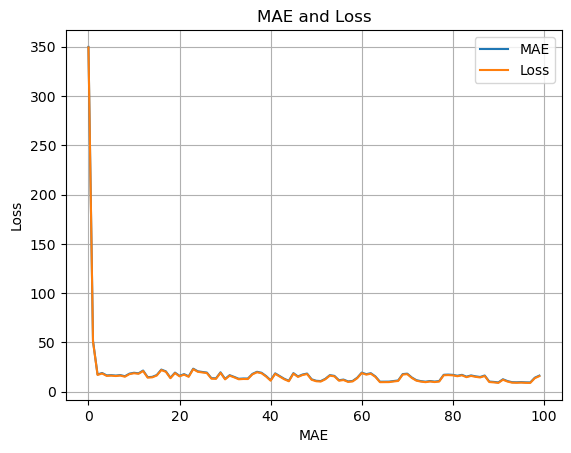

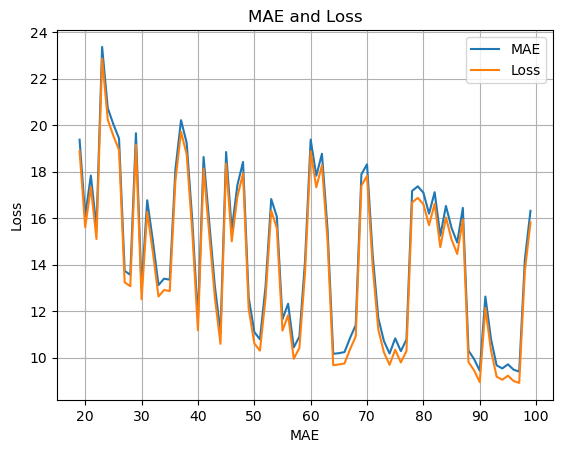

In [32]:
visualize_mae_loss(history)

In [33]:
pred_series = series[SPLIT_TIME-WINDOW_SIZE:-1]

In [34]:
forecast = model_forecast(model, pred_series, WINDOW_SIZE, BATCH_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 0s 12ms/step


In [35]:
results = forecast.squeeze()

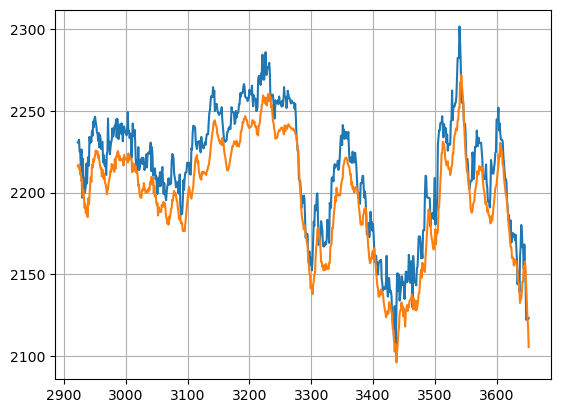

In [36]:
plot_series(time_valid, (series_valid, results))